# HIST OF EXTRACTION OF SYMMETRIES

In [ ]:
from template_csp import managetemp_withdict as mte
import numpy as np  
import json
import matplotlib.pyplot as plt

test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 
    "comp" : 1,
    "lev_red" : 0.9,
    "n_pairs" : 105,
}

complist = [1,2,3,4]
tempinit = 25
tempend = 25 #compreso
mother_dir = './HvsINIT/'

for comp in complist:
    hyperparameters["comp"] = comp  
    same_struct = {}
    with open(f'./SAME_STRUCT_DICT/same_structuresA{comp}B.json') as f:
        same_struct = json.load(f)

    if comp == 1:
        hyperparameters["n_pairs"] = 105
    else:
        hyperparameters["n_pairs"] = 210

    for temp_tot in range(tempinit, tempend +1):
        average_res = 0
        for id_set in range(20):
            init_set = mte.TemplateSet(test_elements=test_elements, hyperparameters=hyperparameters, restart_file=mother_dir+f'{comp}/{temp_tot}/TemplateSet_{id_set}')
            fin_set = mte.PairSet(template_set=init_set, test_elements=test_elements, hyperparameters=hyperparameters, relaxed_pairs=mother_dir+f'{comp}/{temp_tot}/PairSet_{id_set}')
            final_set_idx = fin_set.reduced_set()
            final_set = [f'{init_set.pairs[x][0][0]}{init_set.pairs[x][0][1]}_{init_set.pairs[x][1]}' for x in final_set_idx]
            average_res += len(final_set)/20
            for temp in final_set:
                for group in same_struct.keys():
                    if temp in same_struct[group]['temp']:
                        same_struct[group]['count'] += 1
                        break
        
        x = [f'{idx}/{key.split(',')[0][1:]}' for idx, key in enumerate(same_struct.keys())]
        x = np.array(x)
        y = [same_struct[key]['count'] for key in same_struct.keys()]
        y = np.array(y)

        idx_sort_y = np.argsort(y)
        x = x[idx_sort_y][::-1]
        y = y[idx_sort_y][::-1]
        

        fig, ax1 = plt.subplots(1, 1, figsize=(14, 8))
        fig.suptitle('FINAL SET COUNT', fontsize=22, y=0.93, fontweight='bold')
        ax1.bar(x, y, color = 'crimson', edgecolor = 'black', linewidth = 2, alpha=0.7)
        ax1.vlines(average_res-1, 0, max(y)+5, colors='blue', linestyles='dashed', label='Average size finale set')
        ax1.set_xlabel('SG (same wyck pos)', fontsize=18)
        ax1.set_xticks(x)
        ax1.set_xticklabels([a.split('/')[1] for a in x], rotation=90)
        ax1.set_ylim(0, max(y)+5)
        ax1.set_ylabel('Count', fontsize=18)
        ax1.legend(loc='upper right', fontsize=16)
        plt.show()
        fig.savefig(f'./FIG/HIST_FINAL_A{comp}B.png')



    

# GENERATE NEW DATA FROM TEMPLATE SET

### SIZE FINAL SET

In [ ]:
from template_csp import managetemp as mte 
import numpy as np
import json
from tqdm import tqdm

test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 
    "comp" : 1,
    "lev_red" : 0.9,
    "n_pairs" : 105,

    "n_final_templates" : 1
}

data = {}

complist = [1,2,3,4,6]
n_set = 20
temp_list = [[20,30,40,50],[30, 45, 60, 75], [30, 40, 50, 60], [30, 40, 50, 60], [10,20,30,35]]

mother_dir = './HvsINIT/'

for comp, temp_steps in tqdm(zip(complist, temp_list)):
    hyperparameters["comp"] = comp
    data[comp] = {}

    if comp == 1:
        hyperparameters["n_pairs"] = 105
    else:
        hyperparameters["n_pairs"] = 210

    for temp_init in temp_steps:
        data[comp][temp_init] = {'errors_before': {}, 'errors_after': {}}

        errors_before = np.zeros((2, temp_init))
        errors_after = np.zeros((2, temp_init))

        for size_final in range(1, temp_init + 1):
            hyperparameters["n_final_templates"] = size_final

            er_aft = []
            er_bef = []

            for id_set in range(n_set):
                init_set = mte.InitialSet(test_elements=test_elements, hyperparameters=hyperparameters, restart_file=mother_dir+f'{comp}/{temp_init}/InitialSet_{id_set}')
                fin_set = mte.generate_final_set(init_set=init_set, hyperparameters=hyperparameters, test_elements=test_elements)

                er_bef.append(init_set.difference_from_uspex())
                er_aft.append(fin_set.difference_from_uspex())
            
            errors_before[0][size_final-1] = np.mean(er_bef)
            errors_before[1][size_final-1] = np.std(er_bef)
            errors_after[0][size_final-1] = np.mean(er_aft)
            errors_after[1][size_final-1] = np.std(er_aft)
        
        data[comp][temp_init]['errors_before']['mean'] = errors_before[0].tolist()
        data[comp][temp_init]['errors_before']['std'] = errors_before[1].tolist()
        data[comp][temp_init]['errors_after']['mean'] = errors_after[0].tolist()
        data[comp][temp_init]['errors_after']['std'] = errors_after[1].tolist()
    
    with open('./Errors1.json', 'w') as f:
        json.dump(data, f, indent=4)
                

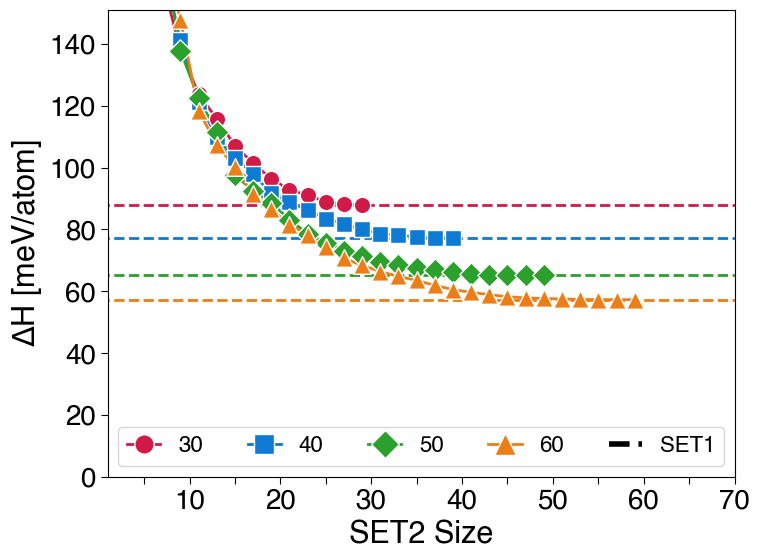

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
import matplotlib

# load font
matplotlib.rcParams['font.family'] = 'Helvetica'

plt.rcParams['font.size'] = 20


with open('DATA_DICT/TrendSizeSet2.json') as f:
    data = json.load(f)

for comp in data.keys():
    if comp != '3':
        continue
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    colorlist = ['red', 'blue', 'green', 'orange']
    colorlist = ["#d11a48", "#0e7ad3", "#2CA02C", "#ec7e17"]
    markerlist = ['o', 's', 'D', '^']
    sizelist = [140, 140, 140, 160]


    for idx, temp_init in enumerate(data[comp].keys()):
        x = np.arange(1, int(temp_init)+1)
        y_bef = data[comp][temp_init]['errors_before']['mean'][0]
        y_aft = data[comp][temp_init]['errors_after']['mean']
    
        ax.hlines(y_bef*1000, 0, 70, color=colorlist[idx], lw=2, linestyle='--')
        ax.plot(x[::2], np.array(y_aft)[::2]*1000, color=colorlist[idx], lw=2)
        ax.scatter(x[::2], np.array(y_aft)[::2]*1000, color=colorlist[idx], marker=markerlist[idx], s=sizelist[idx], edgecolor='white', zorder = 10)

        ax.add_artist(plt.Line2D((-10, -10), (0, 0), color=colorlist[idx], marker=markerlist[idx], markersize=sizelist[idx]/10, markeredgecolor='white', linestyle='solid', lw=2, label=f'{temp_init}'))

    # ax.add_artist(plt.Line2D((0, 0), (0, 0),marker='o', markersize=15, color='black', linestyle='solid', lw=4, label='SET2'))
    ax.add_artist(plt.Line2D((-10, -10), (0, 0), color='black', linestyle='dashed', lw=4, label='SET1'))

    ax.set_xlabel('SET2 Size', fontsize=22)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xticklabels([f'{x:.0f}' for x in np.arange(0, 101, 10)])
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))

    max_y = 151
    min_y = 0

    ax.set_ylabel(r'$\Delta$H [meV/atom]', fontsize=22)
    ax.yaxis.set_major_locator(plt.MultipleLocator(20))

    ax.tick_params(size=5, labelsize=20)


    ax.legend(loc='lower center', ncol=6, handlelength=1.5, fontsize=16)
    ax.set_xlim(1,70)
    ax.set_ylim(min_y,max_y)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'./FIG/Articolo/SET2_DH.svg', dpi=300, bbox_inches='tight')

### VALIDATION PAIRS CONTINUUM

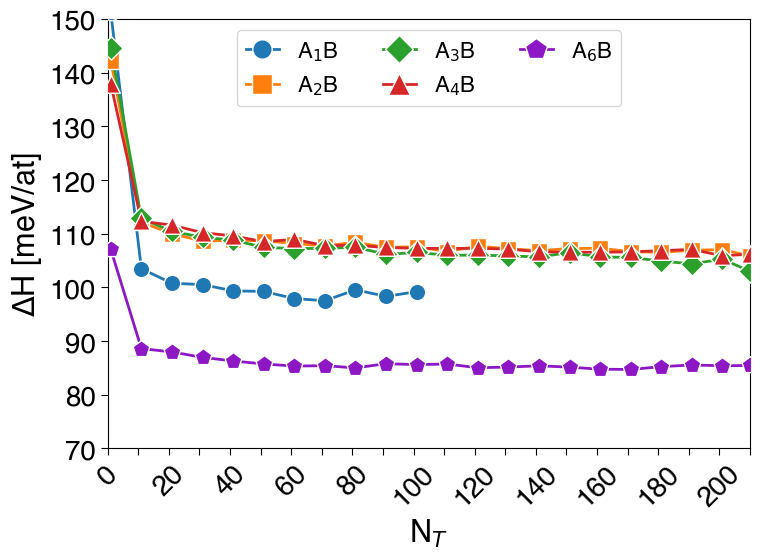

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import json
import matplotlib

matplotlib.rcParams['font.family'] = 'Helvetica'

plt.rcParams['font.size'] = 20

name_file = 'DATA_DICT/TrendsNumberOfPairs/NumberOfPairs_Normal_RenormalizedSub.json'
with open(name_file) as f:
    data = json.load(f)

markerlist = ['o', 's', 'D', '^', 'p']
sizelist = [140, 140, 140, 160, 160]
colorlist = ['#1f77b4', '#ff7f0e', "#2CA02C", '#d62728', "#8d17c4"]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for idx, comp in enumerate(data.keys()):

    for temp_init in data[comp]['ErrBef'].keys():

        x = []

        y_aft = []
        std_aft = []

        for npair in data[comp]['ErrAft'][str(temp_init)].keys():
            x.append(int(npair))
            y_aft.append(data[comp]['ErrAft'][str(temp_init)][npair])

        ax.plot(x[::2], np.array(y_aft)[::2]*1000, color=colorlist[idx], lw=2)
        ax.scatter(x[::2], np.array(y_aft)[::2]*1000, color=colorlist[idx], marker=markerlist[idx], s=sizelist[idx], edgecolor='white', zorder = 10)
        ax.add_artist(plt.Line2D((-10, -10), (0, 0), color=colorlist[idx], marker=markerlist[idx], markersize=sizelist[idx]/10, markeredgecolor='white', linestyle='solid', lw=2, label=f'A$_{comp}$B'))
        
tot_pairs = 210
step_x = 20
ax.set_xlabel(r'N$_T$', fontsize=22)
ax.set_xticks(np.arange(0, tot_pairs+1, step_x))
ax.set_xticklabels([f'{x:.0f}' for x in np.arange(0, tot_pairs+1, step_x)], rotation=45)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))

ax.set_ylabel(r'$\Delta$H [meV/at]', fontsize=22)
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax.tick_params(size=5, labelsize=20)


ax.legend(loc='upper center', fontsize=16, ncol=3, handlelength=1.5)
ax.set_xlim(0, x[-1])
ax.set_ylim(70, 150)

plt.tight_layout()
plt.show()

fig.savefig(f'./FIG/Articolo/NT.svg', dpi=300, bbox_inches='tight')